In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.feature_selection import RFE

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df = pd.read_csv('X:\RA_AirQuality\combined_final_dataset.csv', index_col='DateTime')

In [3]:
df.head()

,TEMP,CO,NO,NO2,PM10,PM2.5,HUM,DIR,SPD,PRES,Month,Hour,TF_CNT
DateTime,,,,,,,,,,,,,
2019-01-01 00:00:00,-13.26,0.28,1.66,7.00,8.62,6.30,80.04,189.90,2.65,625.00,1,0,2042.0
2019-01-01 01:00:00,-14.22,0.27,0.66,6.00,8.71,4.41,75.21,282.43,2.70,625.24,1,1,1949.0
2019-01-01 02:00:00,-14.30,0.29,0.63,7.31,6.82,5.24,79.09,310.47,2.26,630.04,1,2,1527.0
2019-01-01 03:00:00,-14.44,0.29,0.56,6.42,9.10,6.56,79.54,295.01,2.18,630.40,1,3,1403.0
2019-01-01 04:00:00,-14.82,0.29,0.72,8.13,5.94,4.70,79.86,298.92,1.55,630.40,1,4,1793.0


In [4]:
df=df[pd.isnull(df['PM2.5'])==False]
# df = df.drop(columns=['Month','Hour'])
df=df.fillna(df.mean())
df.isnull().values.any()

False

In [5]:
y = df['PM2.5']
X = df.drop(['PM2.5'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

Best alpha using built-in LassoCV: 1.019116
Best score using built-in LassoCV: 0.722614

TEMP     -0.033574
CO       -0.000029
NO        0.015057
NO2       0.007792
PM10      0.382318
HUM       0.057824
DIR      -0.000364
SPD      -0.000000
PRES     -0.000000
Month    -0.000000
Hour      0.000000
TF_CNT   -0.000018
dtype: float64

Lasso picked 8 variables and eliminated the other 4 variables

Chosen variables are: ['TEMP', 'CO', 'NO', 'NO2', 'PM10', 'HUM', 'DIR', 'TF_CNT']


Text(0.5, 1.0, 'Feature importance using Lasso Model')

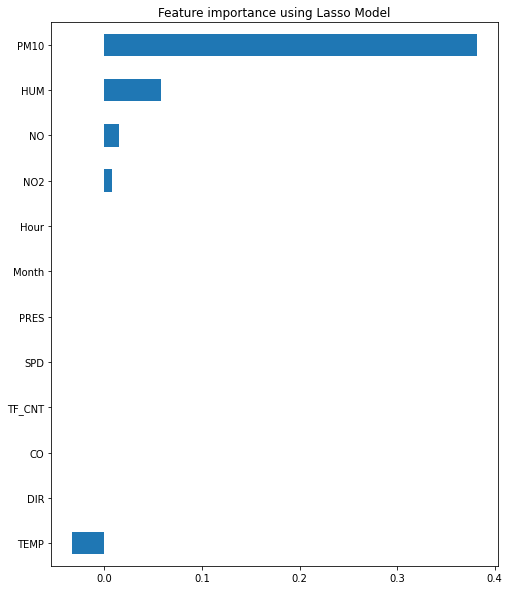

In [6]:
# LASSO REGULARIZATION METHOD

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f\n" %reg.score(X,y))

coef = pd.Series(reg.coef_, index = X.columns)
print(coef)

print("\nLasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
chosen = coef[coef != 0].index
chosen = list(chosen)
print("\nChosen variables are:", chosen)
    
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [7]:
# # RECURSIVE FEATURE ELIMINATION METHOD

# cols = list(X_train.columns)
# model = LinearRegression()

# #Initializing RFE model
# rfe = RFE(model, 5)

# #Transforming data using RFE
# X_rfe = rfe.fit_transform(X_train,y_train)

# #Fitting the data to model
# model.fit(X_rfe,y_train)
# print(rfe.support_)
# print(rfe.ranking_)
# temp = pd.Series(rfe.support_,index = cols)
# selected_features_rfe = temp[temp==True].index
# print(selected_features_rfe)

In [8]:
# # BACKWARD ELIMINATION METHOD

# import statsmodels.api as sm
# #Adding constant column of ones, mandatory for sm.OLS model
# X_1 = sm.add_constant(X_train)
# #Fitting sm.OLS model
# model = sm.OLS(y_train,X_1).fit()
# print(model.pvalues)

In [9]:
chosen.append('PM2.5')
df = df.filter(chosen)

In [10]:
# GRANGER CAUSALITY TEST (Exhaustive Graphical Granger)

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

gc = grangers_causation_matrix(df, variables = df.columns)

In [11]:
gc

,TEMP_x,CO_x,NO_x,NO2_x,PM10_x,HUM_x,DIR_x,TF_CNT_x,PM2.5_x
TEMP_y,1.0000,0.0074,0.0000,0.0000,0.0000,0.0000,0.0828,0.0000,0.0000
CO_y,0.1357,1.0000,0.8216,0.6910,0.7296,0.2507,0.1267,0.1334,0.6635
NO_y,0.0000,0.9864,1.0000,0.0000,0.0001,0.0000,0.0214,0.0000,0.0000
NO2_y,0.0000,0.5163,0.0000,1.0000,0.0000,0.0000,0.0503,0.0000,0.0000
PM10_y,0.0000,0.7810,0.0000,0.0000,1.0000,0.0000,0.2894,0.0000,0.0000
HUM_y,0.0000,0.0003,0.0000,0.0000,0.0000,1.0000,0.1109,0.0000,0.0000
DIR_y,0.0000,0.9107,0.1707,0.0085,0.0008,0.0002,1.0000,0.1351,0.0023
TF_CNT_y,0.0000,0.0326,0.0000,0.0000,0.0000,0.0000,0.0313,1.0000,0.0000
PM2.5_y,0.0000,0.8354,0.0000,0.0000,0.0000,0.0000,0.4443,0.0000,1.0000


In [12]:
import networkx as nx

In [13]:
# Directed Graphical Granger Model (All features included)

DG = nx.DiGraph()
DG.add_nodes_from(gc.columns)
i = 0
for x in gc:
    for y in range(8):
        if(gc[x][y] < 0.05):
            sizex = len(x)
            sizey = len(gc[x].index[y])
            DG.add_edge(x[:sizex - 2], gc[x].index[y][:sizey - 2])
#             print(x[:sizex - 2], 'causes', gc[x].index[y][:sizey - 2])

all_nodes = list(DG.nodes)
all_nodes = all_nodes[:8]
for x in all_nodes:
    DG.remove_node(x)
DG.remove_node('PM2.5_x')

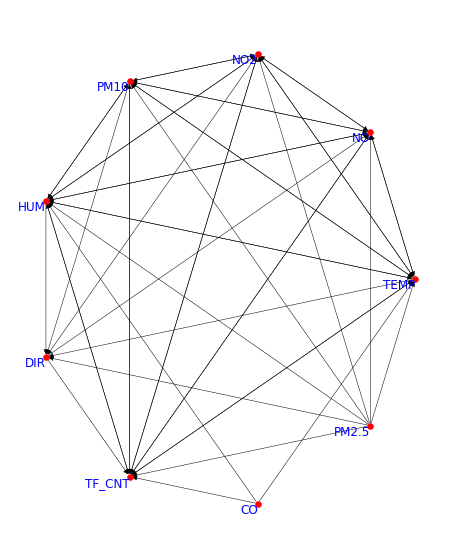

In [14]:
options = {
    'node_color': 'red',
    'node_size': 30,
    'width': 0.5,
}
plt.subplot()
nx.draw_circular(DG, with_labels=True,font_size=12, font_color='blue',horizontalalignment='right',verticalalignment='top', **options)

In [15]:
# Directed graphical granger model (PM2.5 isolated)

DG = nx.DiGraph()
DG.add_nodes_from(gc.columns)
i = 0
for x in gc:
    if(gc[x][8] < 0.05):
        sizex = len(x)
        DG.add_edge(x[:sizex - 2], 'PM2.5')
        print(x[:sizex - 2], 'causes PM2.5')

all_nodes = list(DG.nodes)
all_nodes = all_nodes[:8]
for x in all_nodes:
    DG.remove_node(x)
DG.remove_node('PM2.5_x')

TEMP causes PM2.5
NO causes PM2.5
NO2 causes PM2.5
PM10 causes PM2.5
HUM causes PM2.5
TF_CNT causes PM2.5


In [16]:
DG.nodes

NodeView(('TEMP', 'PM2.5', 'NO', 'NO2', 'PM10', 'HUM', 'TF_CNT'))

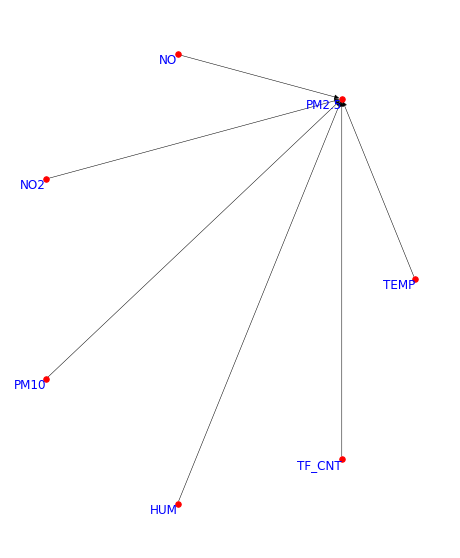

In [17]:
options = {
    'node_color': 'red',
    'node_size': 30,
    'width': 0.5,  
}
plt.subplot()
nx.draw_circular(DG, with_labels=True,font_size=12, font_color='blue',horizontalalignment='right',verticalalignment='top', **options)

In [24]:
listIndex = list(coef.index)
listValue = list(coef)
zip_iterator = zip(listIndex, listValue)

dictCoef = dict(zip_iterator)
print(dictCoef)

{'TEMP': -0.033573833458986374, 'CO': -2.8784935849526638e-05, 'NO': 0.015057470231841244, 'NO2': 0.007792238310857473, 'PM10': 0.3823175857828116, 'HUM': 0.05782438369701032, 'DIR': -0.0003640768013408609, 'SPD': -0.0, 'PRES': -0.0, 'Month': -0.0, 'Hour': 0.0, 'TF_CNT': -1.8118091777571903e-05}


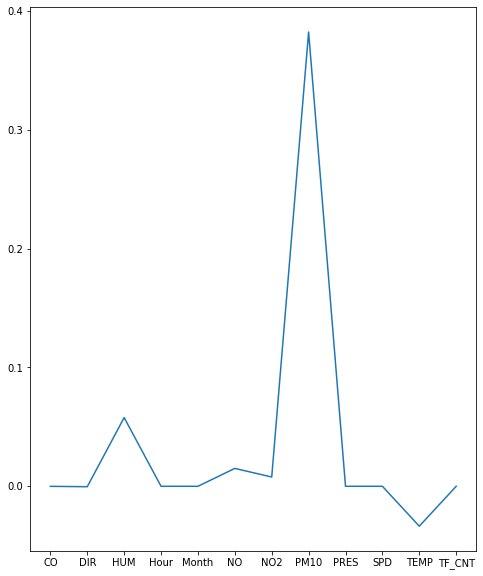

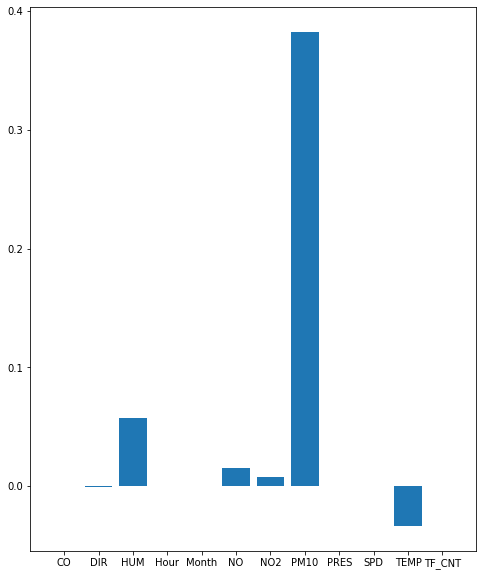

In [38]:
plt.plot(*zip(*sorted(dictCoef.items())))
plt.show()
plt.bar(*zip(*sorted(dictCoef.items())))
plt.show()

<AxesSubplot:>

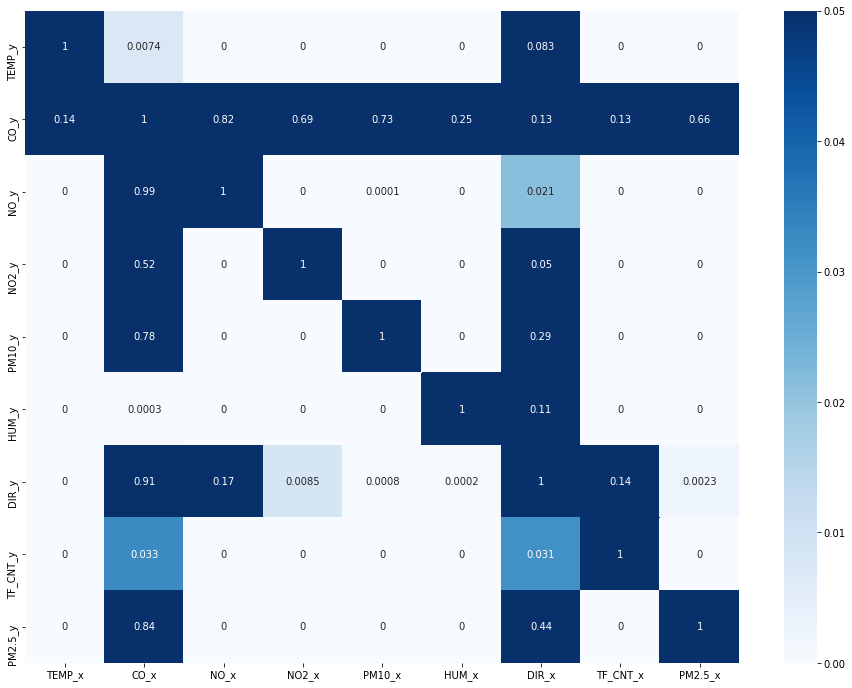

In [39]:
import matplotlib
matplotlib.rc('figure', figsize=(16, 12))

import seaborn as sns
# sns.heatmap(gc, cmap='Blues', annot=True)
sns.heatmap(gc, cmap='Blues', vmin=0, vmax=0.05, annot=True)

# Closer to zero = Higher Granger Causality Score (X causes Y with given score)
# Dark Blues are all rejection (X does not cause Y)